# Contents:
- Data preparation
- K-means Clusterisation of stations occupancy for weekdays and for weekends
- Interactive Leaflet maps of Dublin w/ stations coloured according to clusterisation
- Rebalancing peak detection 
- Reading weather data, making categorical and dummy weather features from text
- Estimating arrival and departure Poisson intensity rates 
- Training ML models
- More fancy graphs

In [732]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import dates as mdates
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = '#f2f2f2'
%matplotlib inline

import os
import re
import json
import urllib
import datetime

# custom module with helper functions

import bss_functions

# reload:
#from importlib import reload
reload(bss_functions)

<module 'bss_functions' from '/Users/mariago/PycharmProjects/bss_project/bss_functions.py'>

In [865]:
reload(bss_functions)

<module 'bss_functions' from '/Users/mariago/PycharmProjects/bss_project/bss_functions.py'>

# Data preparation

In [279]:
# Read the data number of bikes at each station

data = pd.DataFrame()
n_obs = []
n_dropped = 0
for file_name in os.listdir('./data/')[:]:
    if 'bikes' in file_name:
        daily_obs = pd.read_csv('./data/' + file_name, index_col = 0)
        date = file_name.split('_')[1].split('.')[0]
        daily_obs.index = (pd.to_datetime(pd.Series(daily_obs.index).apply(lambda x: ' '.join([date, x]))))
        if len(daily_obs) > 700:
            n_obs.append(len(daily_obs))
            data = pd.concat([data, daily_obs],axis = 0)
        else:
            n_dropped += 1
n_obs = np.array(n_obs)
bss_functions.describe_data(data, 'data', n_obs, n_dropped)


    Collected data for:
              • 128 days without missing observations;
              • 60 days with 1 to 20 missing values.
    14 days with more than 20 missing values were dropped.

    The data covers the period from 24 January 2017 00:00 to 14 August 2017 00:00


In [280]:
# Delete the stations for which the data wasn't always available

del data['CHATHAM_STREET'], data['CLARENDON_ROW'], data['JAMES_STREET_EAST']

# Read coordinates of bicycle stations

stations = pd.read_csv('./data/station_locations.csv')
stations['Name'] = stations.Name.apply(lambda x: x.replace("'", ""))

# Calculate elevation of each station
# altitudes = [bss_functions.altitude(stations.Latitude[i], stations.Longitude[i]) for i in range(stations.shape[0])]

# Load pre-calculated elevation of each station

import pickle
f = open('./data/altitudes.dat', 'rb')
altitudes = pickle.load(f)
stations['Alt'] = altitudes

# Calculate capacity (the number of locks at each station)

capacity = pd.DataFrame({'Name': data.T.index.values, 'Capacity': data.max(0)})
capacity.Name = capacity.Name.apply(lambda x: x.replace('_', ' ').replace("'", ""))
stations = stations.merge(capacity, on = 'Name', how = 'inner')

# plot elevation of each station using custom function

#bss_functions.plot_elevation_map(stations, stations.Latitude, stations.Longitude, stations.Name, stations.Alt)

# Patterns of use: weekdays vs weekends

In [281]:
# Build up a time series of each station averaged over weekdays and weekends

df_copy = data.copy()
df_copy['weekday'] = df_copy.index.weekday
df_copy['date'] = df_copy.index.date
weekdays = df_copy.loc[df_copy['weekday'] < 5].drop(['weekday'], 1)
weekends = df_copy.loc[df_copy['weekday'] >= 5].drop(['weekday'], 1)
holidays = [datetime.date(2017, y, x) for [y, x] in zip([3, 4, 5, 6, 8], [17, 17, 1, 5, 7])]
for i in holidays:
    weekdays.drop(weekdays.index[weekdays.index.date == i], 0, inplace=True)    

# Resample by 5 min and backfill nans

weekdays = weekdays.resample('5T').mean().bfill()
weekends = weekends.resample('5T').mean().bfill() 

# Group by minute of day and take average for each station

weekdays['time'] = weekdays.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))
weekdays = weekdays.groupby('time').agg('mean').astype(int)
weekends['time'] = weekends.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))
weekends = weekends.groupby('time').agg('mean').astype(int)

# Normalise each station between 0 and 1 as each station has different capacity
weekdays_norm = weekdays / weekdays.max()
weekends_norm = weekends / weekends.max()

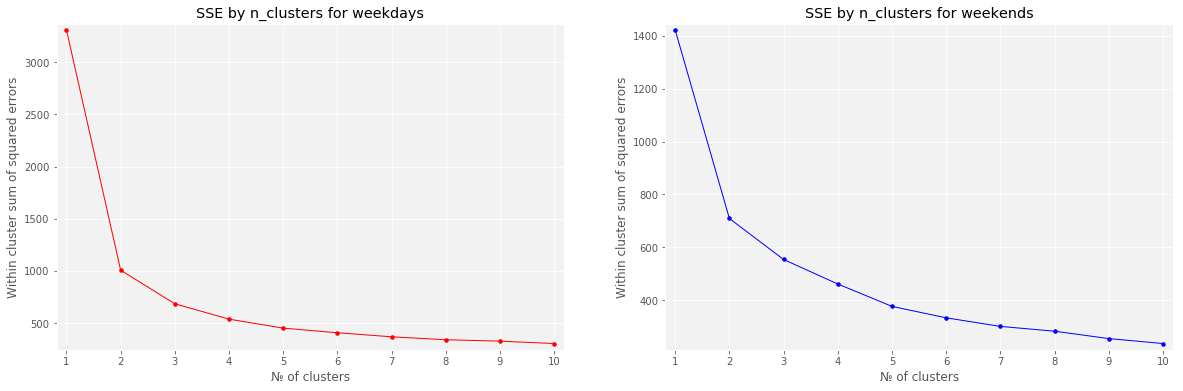

In [5]:
# Choose a suitable number of clusters using elbow method (mostly to support the intuition)
# 3 clusters can be selected both for the weekdays and weekends

bss_functions.plot_SSE(weekdays_norm, weekends_norm)

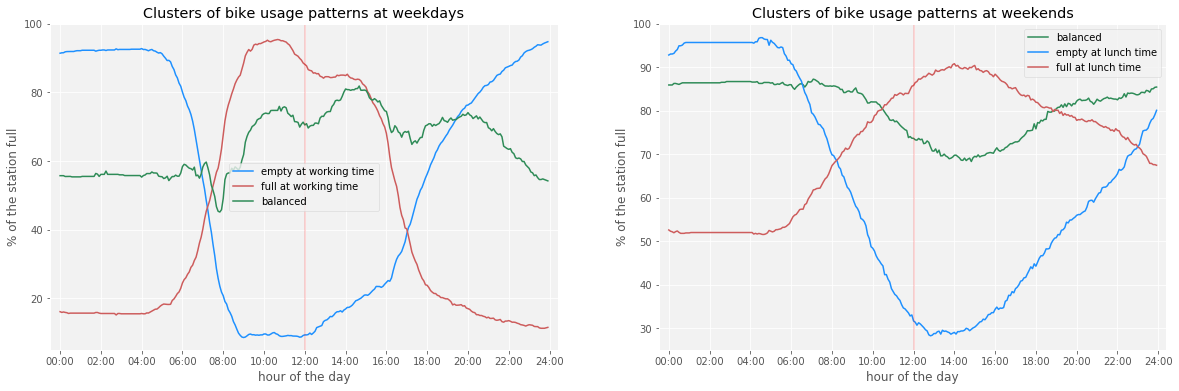

In [6]:
# K-means clustering to detect patterns in bike usage during weekdays and weekends
cluster_colours_wd = ['dodgerblue', 'indianred', 'seagreen']
cluster_colours_we = ['seagreen', 'dodgerblue', 'indianred']
clusters_weekdays, clusters_weekends = bss_functions.plot_cluster_usage_patterns(weekdays_norm, 
                                                                                 weekends_norm, 
                                                                                 cluster_colours_wd,
                                                                                 cluster_colours_we)


In [682]:
# Color stations based on their weekday usage pattern
# if the map is not rendering in Chrome, see clusters_wd_map.html in the project folder

folium_map = bss_functions.plot_clusters_map(stations, weekdays_norm, 
                                           clusters_array=clusters_weekdays, 
                                           cluster_colours=cluster_colours_wd)
folium_map.save('weekdays_map.html')
folium_map

In [684]:
# Color stations based on their weekend usage pattern
# if the map is not rendering in Chrome, see clusters_we_map.html in the project folder


#folium_map_1 = bss_functions.plot_clusters_map(stations, weekends_norm, 
#                                           clusters_array=clusters_weekends, 
#                                           cluster_colours=cluster_colours_we)
#folium_map_1.save('weekends_map.html')
#folium_map_1

# Some examples of different patterns of use

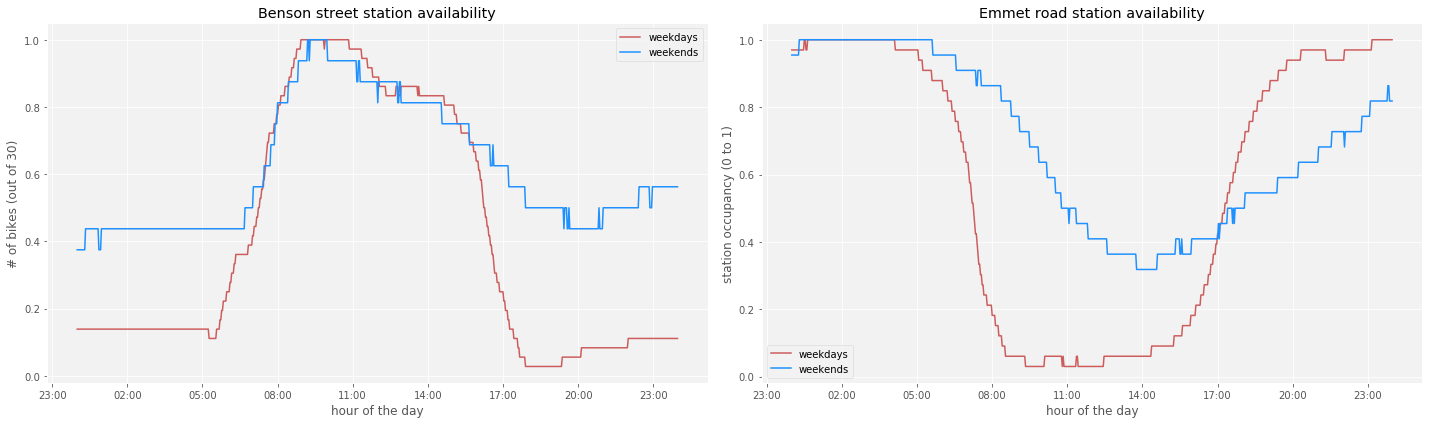

In [679]:
# BENSON_STREET: near the U2 tower; probably many people are working on Sat and Sun too, so no shift
# EMMET_ROAD: outskirts of the city

bss_functions.plot_usage_examples(data, 'BENSON_STREET', 'EMMET_ROAD')

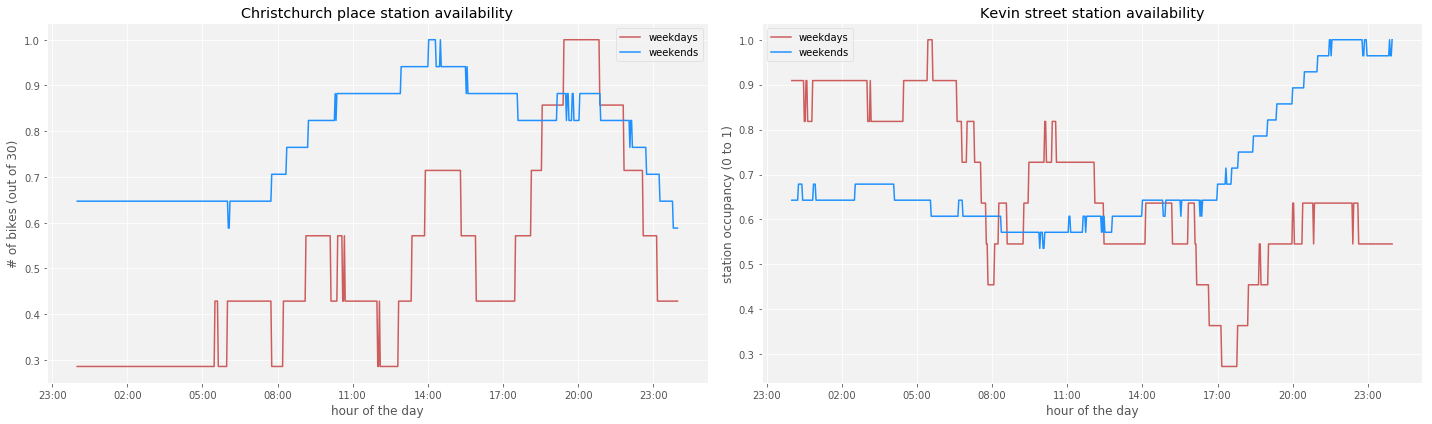

In [680]:
# CHRISTCHURCH_PLACE: tourist attractions nearby (Christ Church cathedral, Dublin Castle, Radisson Blu hotel)
# KEVIN_STREET: Dublin Institute of Technology => used by students

bss_functions.plot_usage_examples(data, 'CHRISTCHURCH_PLACE', 'KEVIN_STREET')

# Rebalancing peak detection

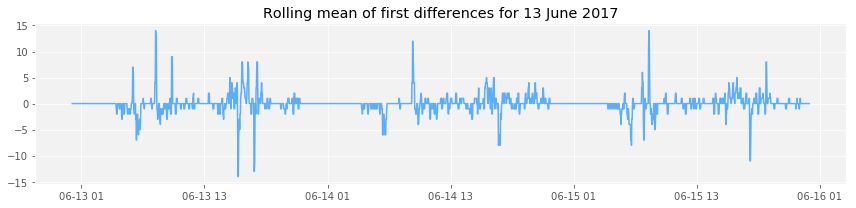

In [863]:
M = 6
D = 13
fig = plt.figure(figsize=(12,3))
day = pb_weekdays[pb_weekdays.index.date == datetime.date(2017, M, D)]
diff = day.diff()
rs = diff.rolling(3, center = False).sum()
plt.plot(rs, color='dodgerblue', alpha = 0.7)

M = 6
D = 14
day = pb_weekdays[pb_weekdays.index.date == datetime.date(2017, M, D)]
diff = day.diff()
rs = diff.rolling(3, center = False).sum()
plt.plot(rs, color='dodgerblue', alpha = 0.7)

M = 6
D = 15
day = pb_weekdays[pb_weekdays.index.date == datetime.date(2017, M, D)]
diff = day.diff()
rs = diff.rolling(3, center = False).sum()
plt.plot(rs, color='dodgerblue', alpha = 0.7)
plt.title('Rolling mean of first differences for 13 June 2017')
fig.savefig('rollingmeandiff.png')
plt.tight_layout()
plt.show()

In [999]:
pb_weekdays = weekdays['PORTOBELLO_ROAD']
pb_weekdays_df = pd.DataFrame(pb_weekdays)
pb_weekdays_df['downward_peak'] = np.zeros(pb_weekdays_df.shape[0])
pb_weekdays_df['upward_peak'] = np.zeros(pb_weekdays_df.shape[0])
days = np.unique(pb_weekdays.index.date)

def expand_downward_peak(indices):
    '''
    this function recieves indices of high downward peaks that are suspected to be caused
    by rebalancing trucks, expands them, i.e. unites them with neighbouring differences if 
    their have co-directional dynamics and checks if each peak suits the pattern of Assumption 1.
    
    returns only indices of those downward peaks that are believed to be caused by rebalancing
    
    '''
    new_indices = []
    for ind in indices:
        ind_temp = [ind]
        i = 0
        while diff[ind-i] <= 0:
            ind_temp = np.append(ind_temp, ind-i-1)
            i += 1
        i = 0
        while diff[ind+i+1] <= 0:
            ind_temp = np.append(ind_temp, ind+i+1)
            i += 1
        if day.iloc[min(ind_temp)]-day.iloc[max(ind_temp)] <= 20 and day.iloc[min(ind_temp)]-day.iloc[max(ind_temp)] >= 5 and day.iloc[max(ind_temp)] >= 1 and (np.mean(day.iloc[max(ind_temp)+1:max(ind_temp)+20]) > day.iloc[max(ind_temp)]): 
            new_indices.append(ind_temp)
    try: new_indices = np.unique([x for subset in new_indices for x in subset])  
    except: pass
    new_indices.sort()
    return new_indices

def expand_upward_peak(indices):
    '''
    this function recieves indices of high upward peaks that are suspected to be caused
    by rebalancing trucks, expands them, i.e. unites them with neighbouring differences 
    if their have co-directional dynamics and checks if each peak suits the pattern of Assumption 1.
    
    returns only indices of those upward peaks that are believed to be caused by rebalancing
    
    '''
    new_indices = []
    for ind in indices:
        ind_temp = [ind]
        i = 0
        while diff[ind-i] >= 0:
            ind_temp = np.append(ind_temp, ind-i-1)
            i += 1
        i = 0
        while diff[ind+i+1] >= 0:
            ind_temp = np.append(ind_temp, ind+i+1)
            i += 1
        if day.iloc[max(ind_temp)]-day.iloc[min(ind_temp)] <= 20 and day.iloc[max(ind_temp)]-day.iloc[min(ind_temp)] >= 5 and day.iloc[max(ind_temp)] <= day.max()-1 and (np.mean(day.iloc[max(ind_temp):max(ind_temp)+20]) < day.iloc[max(ind_temp)] or np.mean(day.iloc[min(ind_temp)-5:min(ind_temp)]) < 1): 
            new_indices.append(ind_temp)
    try: new_indices = np.unique([x for subset in new_indices for x in subset])  
    except: pass
    new_indices.sort()
    return new_indices

# Finding suspicious high peaks using rolling mean of first differences, then inputing their
# indices in expand functions; each index that is believed to belong to a rebalancing peak
# gets a positive value (1 or 2) in upward_peak or downward_peak column as opposed to 0s

for i in days:
    day = pb_weekdays[pb_weekdays.index.date == i]
    diff = day.diff()
    rs = diff.rolling(3, center = False).sum()
    indices = np.hstack([np.where(diff < -7)[0], np.where(rs <= -7)[0]])
    try: index_last = np.where(rs <= -7)[0][-1]
    except: pass
    indices = [x for subset in [indices, [index_last]] for x in subset]
    indices = expand_downward_peak(indices)
    for j in indices:
        pb_weekdays_df.loc[day.index[j], 'downward_peak'] = 1
    try: index_last_down = indices[-1]
    except: pass
    inds = np.append(indices[np.where(np.diff(indices) > 1)], index_last_down)
    for j in inds:
        pb_weekdays_df.loc[day.index[int(j)], 'downward_peak'] = 2   
        
    indices = np.hstack([np.where(diff > 7)[0], np.where(rs >= 7)[0]])
    try: index_last_1 = np.where(rs >= 7)[0][-1]
    except: pass
    indices = [x for subset in [indices, [index_last_1]] for x in subset]
    indices = expand_upward_peak(indices)
    for j in indices:
        pb_weekdays_df.loc[day.index[j], 'upward_peak'] = 1
    try: index_last_up = indices[-1]
    except: pass
    inds = np.append(indices[np.where(np.diff(indices) > 1)], index_last_up)
    for j in inds:
        pb_weekdays_df.loc[day.index[int(j)], 'upward_peak'] = 2

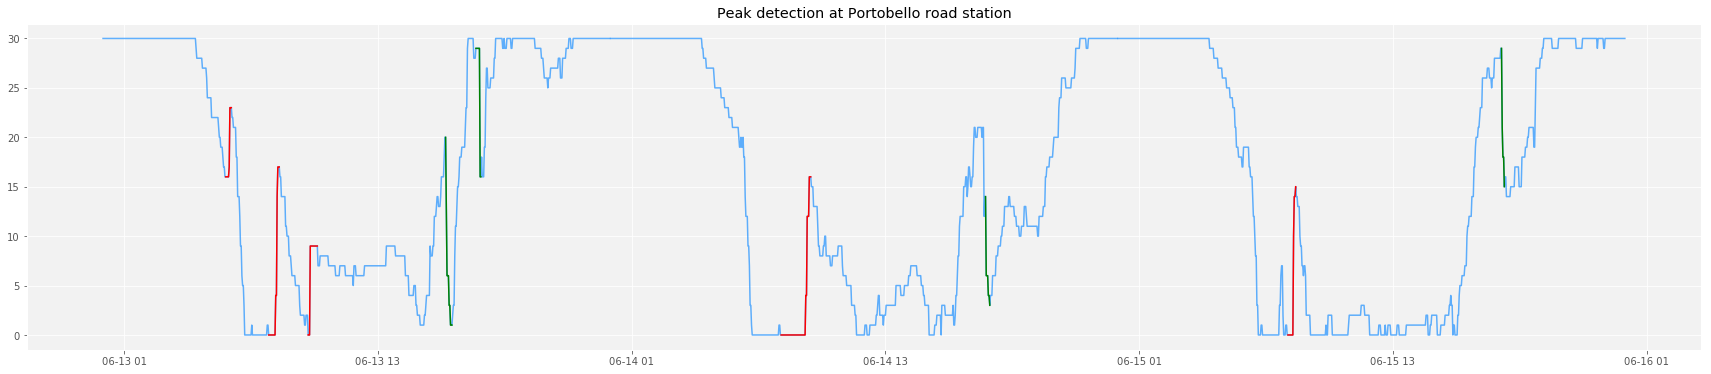

In [864]:
fig = plt.figure(figsize=(30,6))
M = 6
D = 13

inds_up = [x for subset in [[0], np.where(pb_weekdays_df[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.upward_peak >= 1)].upward_peak == 2)[0]] for x in subset]
plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[pb_weekdays_df.index.date == datetime.date(2017,M,D)], color = 'dodgerblue', alpha = 0.7)
for i in range(len(inds_up)-1):
    plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.upward_peak >= 1)][inds_up[i]+1:inds_up[i+1]+1], color = 'r')
inds_down = [x for subset in [[0], np.where(pb_weekdays_df[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.downward_peak >= 1)].downward_peak == 2)[0]] for x in subset]
for i in range(len(inds_down)-1):
    plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.downward_peak >= 1)][inds_down[i]+1:inds_down[i+1]+1], color = 'g')
plt.title('Peak detection at Portobello road station')

M = 6
D = 14

inds_up = [x for subset in [[0], np.where(pb_weekdays_df[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.upward_peak >= 1)].upward_peak == 2)[0]] for x in subset]
plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[pb_weekdays_df.index.date == datetime.date(2017,M,D)], color = 'dodgerblue', alpha = 0.7)
for i in range(len(inds_up)-1):
    plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.upward_peak >= 1)][inds_up[i]+1:inds_up[i+1]+1], color = 'r')
inds_down = [x for subset in [[0], np.where(pb_weekdays_df[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.downward_peak >= 1)].downward_peak == 2)[0]] for x in subset]
for i in range(len(inds_down)-1):
    plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.downward_peak >= 1)][inds_down[i]+1:inds_down[i+1]+1], color = 'g')

    
M = 6
D = 15

inds_up = [x for subset in [[0], np.where(pb_weekdays_df[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.upward_peak >= 1)].upward_peak == 2)[0]] for x in subset]
plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[pb_weekdays_df.index.date == datetime.date(2017,M,D)], color = 'dodgerblue', alpha = 0.7)
for i in range(len(inds_up)-1):
    plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.upward_peak >= 1)][inds_up[i]+1:inds_up[i+1]+1], color = 'r')
inds_down = [x for subset in [[0], np.where(pb_weekdays_df[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.downward_peak >= 1)].downward_peak == 2)[0]] for x in subset]
for i in range(len(inds_down)-1):
    plt.plot(pb_weekdays_df.PORTOBELLO_ROAD[(pb_weekdays_df.index.date == datetime.date(2017,M,D)) & (pb_weekdays_df.downward_peak >= 1)][inds_down[i]+1:inds_down[i+1]+1], color = 'g')

fig.savefig('peak_detection.png')

plt.show()

# Read and transform weather data

In [728]:
# Read the data collected from weather.com

weather = pd.DataFrame()
n_obs = []
n_dropped = 0
for file_name in os.listdir('./data/')[:]:
    if 'weather' in file_name:
        daily_obs = pd.read_csv('./data/' + file_name, index_col = 0)
        date = file_name.split('_')[1].split('.')[0]
        daily_obs.index = (pd.to_datetime(pd.Series(daily_obs.index).apply(lambda x: ' '.join([date, x]))))
        if len(daily_obs) > 700:
            n_obs.append(len(daily_obs))
            weather = pd.concat([weather, daily_obs],axis = 0)
        else:
            n_dropped += 1
n_obs = np.array(n_obs)
bss_functions.describe_data(weather, 'weather data', n_obs, n_dropped)


    Collected weather data for:
              • 128 days without missing observations;
              • 60 days with 1 to 20 missing values.
    14 days with more than 20 missing values were dropped.

    The data covers the period from 24 January 2017 00:00 to 14 August 2017 00:00


In [729]:
# Feature engineering

# Create dummy features from text description of the weather, then add intensity factor

weather = bss_functions.get_weather_features(weather)

# Resample by 1 min and interpolate with mean

features = pd.DataFrame({'Temperature': weather.resample('1T')['Temperature'].mean().interpolate(),
                          'Feels_Like': weather.resample('1T')['Feels_Like'].mean().interpolate(),
                          'Wind_Speed': weather.resample('1T')['Wind_Speed'].mean().interpolate(),
                          'Snow': weather.resample('1T')['Snow'].mean().interpolate(),
                          'Rain': weather.resample('1T')['Rain'].mean().interpolate(),  
                          'Clouds': weather.resample('1T')['Clouds'].mean().interpolate(),
                          'Fog': weather.resample('1T')['Fog'].mean().interpolate(),
                          'Thunder': weather.resample('1T')['Thunder'].mean().interpolate(),
                          'Hail': weather.resample('1T')['Hail'].mean().interpolate(), 
                                })

# Add categorical variable denoting month and dummy variables denoting season

features = bss_functions.get_seasonal_features(features)
features.head(3)

,Clouds,Feels_Like,Fog,Hail,Rain,Snow,Temperature,Thunder,Wind_Speed,Month,Spring,Summer,Winter
Time,,,,,,,,,,,,,
2017-01-24 00:00:00,1.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,24.0,1,0,0,1
2017-01-24 00:01:00,1.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,24.0,1,0,0,1
2017-01-24 00:02:00,1.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,24.0,1,0,0,1


In [703]:
# Keep warm months and no precipitations

df_copy = data.copy()
df_copy['weekday'] = df_copy.index.weekday
df_copy['date'] = df_copy.index.date
weekdays = df_copy.loc[df_copy['weekday'] < 5].drop(['weekday'], 1)
weekends = df_copy.loc[df_copy['weekday'] >= 5].drop(['weekday'], 1)
holidays = [datetime.date(2017, 3, 17), datetime.date(2017, 4, 17), datetime.date(2017, 5, 1), datetime.date(2017, 6, 5), datetime.date(2017, 8, 7)]
for i in holidays:
    weekdays.drop(weekdays.index[weekdays.index.date == i], 0, inplace=True)    
for i in [1,2,3,4]:
    weekdays.drop(weekdays.index[weekdays.index.month == i], 0, inplace=True) 

# Estimating arrival and departure rates
### (# of events per hour) for different steps of piecewise-constant Poisson processes; graphs for Portobello road

- red graph shows rates estimated ignoring the fact that at certain times the rates can't be observed due to station capacity census.

- blue graph shows rates estimated by the adjusted formula observing only that part of each time interval where calculated rate can be observed, i.e. it was not completely full or empty for arrival and departure rates calculation, respectively

the rates do not count rebalancing peaks

In [868]:
reload(bss_functions)

<module 'bss_functions' from '/Users/mariago/PycharmProjects/bss_project/bss_functions.py'>

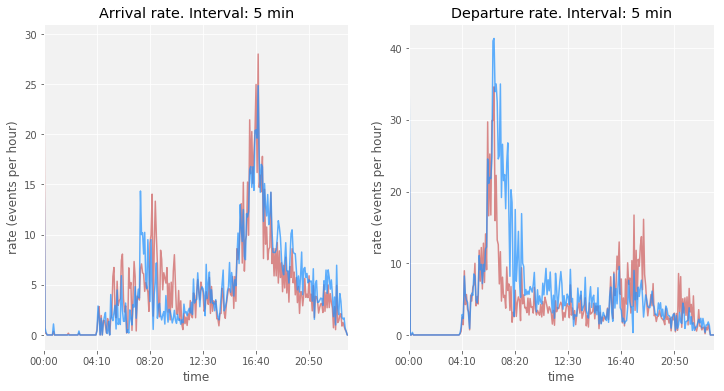

In [869]:
ar, ar_adj, dep, dep_adj = bss_functions.estimate_adjusted_rate(pb_weekdays_df, 'PORTOBELLO_ROAD', step_size=5)

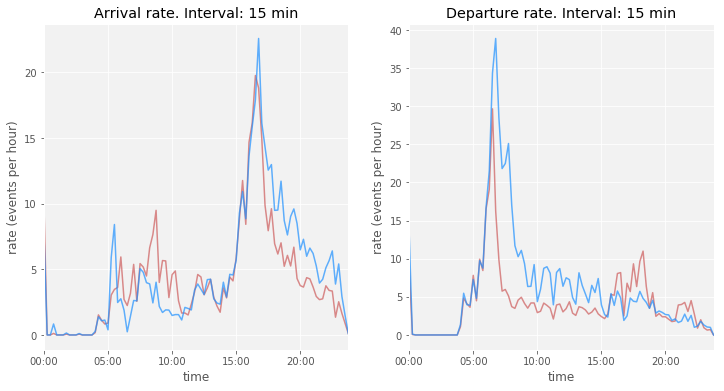

In [870]:
ar, ar_adj, dep, dep_adj = bss_functions.estimate_adjusted_rate(pb_weekdays_df, 'PORTOBELLO_ROAD', step_size=15)

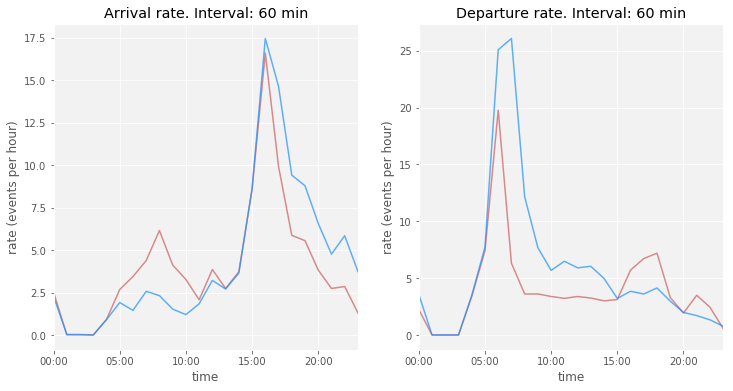

In [872]:
ar, ar_adj, dep, dep_adj = bss_functions.estimate_adjusted_rate(pb_weekdays_df, 'PORTOBELLO_ROAD', step_size=60)

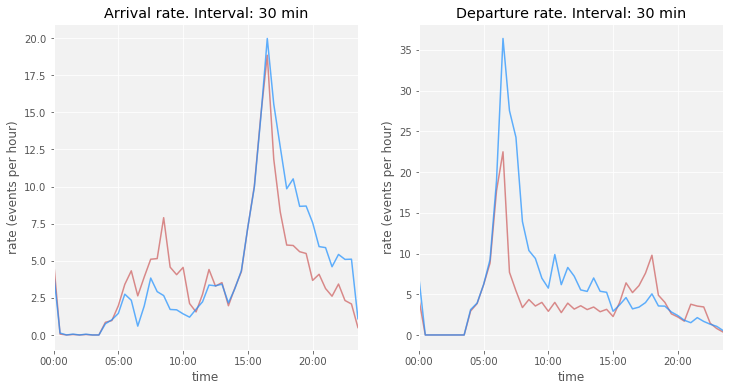

In [889]:
ar, ar_adj, dep, dep_adj = bss_functions.estimate_adjusted_rate(pb_weekdays_df, 'PORTOBELLO_ROAD', step_size=30)

# Using estimates to predict unobserved demand

In [890]:
ar_adj.index = pd.to_datetime(ar_adj.index)
ar_adj = ar_adj.resample('2T').mean().interpolate()
dep_adj.index = pd.to_datetime(dep_adj.index)
dep_adj = dep_adj.resample('2T').mean().interpolate()

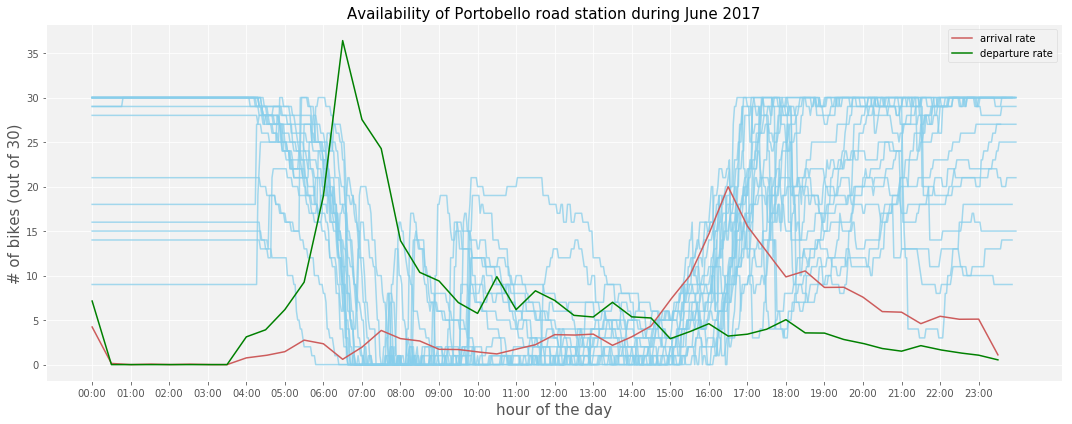

In [891]:
data['DATE'] = [x.date() for x in data.index]
data.columns = [x.replace("'",'') for x in data.columns.values]
weekdays['DATE'] = [x.date() for x in weekdays.index]
range_ = range(1, 31)
colors = ['skyblue']
figure, axis_weekdays = plt.subplots(1, 1, figsize=(15, 6))

for x, col in zip(range_, colors*len(range_)):
    for y in [6]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['PORTOBELLO_ROAD'].values, alpha = 0.75, color = col,label='_nolegend_')
xticks = axis_weekdays.get_xticks()
xticks = range(0, 720, 30)
xticks_labels = ["%02d:%02d" % divmod(i*2, 60) for i in [int(tick) for tick in xticks]]
axis_weekdays.set_xticks(xticks)
axis_weekdays.set_xticklabels(xticks_labels)
axis_weekdays.tick_params(axis = 'both', labelsize = 10)

plt.ylabel('# of bikes (out of 30)')
plt.xlabel('hour of the day')
axis_weekdays.xaxis.label.set_fontsize(15)
axis_weekdays.yaxis.label.set_fontsize(15)

plt.title('Availability of Portobello road station during June 2017')
axis_weekdays.title.set_fontsize(15)

axis_weekdays.plot(ar_adj.values, 'indianred', alpha = 1, label = 'arrival rate')
axis_weekdays.plot(dep_adj.values, 'g', alpha = 1, label = 'departure rate')

axis_weekdays.legend()

figure.savefig('june_availability.png')
plt.tight_layout()
plt.show()

In [893]:
ar_adj.index = ar_adj.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))
dep_adj.index = dep_adj.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))

In [1004]:
day = pb_weekdays_df[pb_weekdays_df.index.date == datetime.date(2017, 7, 17)][['PORTOBELLO_ROAD', 'peak']]

day = day.resample('2T').mean().bfill()

In [1173]:
pb_weekdays_df['peak'] = pb_weekdays_df.downward_peak + pb_weekdays_df.upward_peak
pb = pb_weekdays_df[['PORTOBELLO_ROAD', 'peak']]
pb = pb.resample('2T').mean().bfill()
ind = pb.index
pb = np.array(pb)
pb_new = []
for i in range(int(pb.shape[0]/720)):
    day = pb[720*i:720*(i+1)]
    shift = 0
    for x in range(720):
        pb_new.append(day[x][0]-shift)
        if day[x][1] != 0:
            shift += day[x+1][0]-day[x][0]

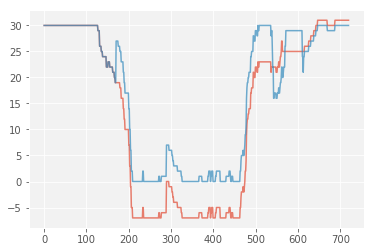

In [1152]:
plt.plot(pb_new[720*7:720*8], alpha = 0.7)
plt.plot(pb[720*7:720*8, 0], alpha = 0.7);

In [1174]:
pb_new = pd.DataFrame(pb_new)
pb_new.index = ind
pb_new['weekday'] = pb_new.index.weekday
pb_new = pb_new.loc[pb_new['weekday'] < 5].drop(['weekday'], 1)
pb_new.columns = ['PORTOBELLO_ROAD']

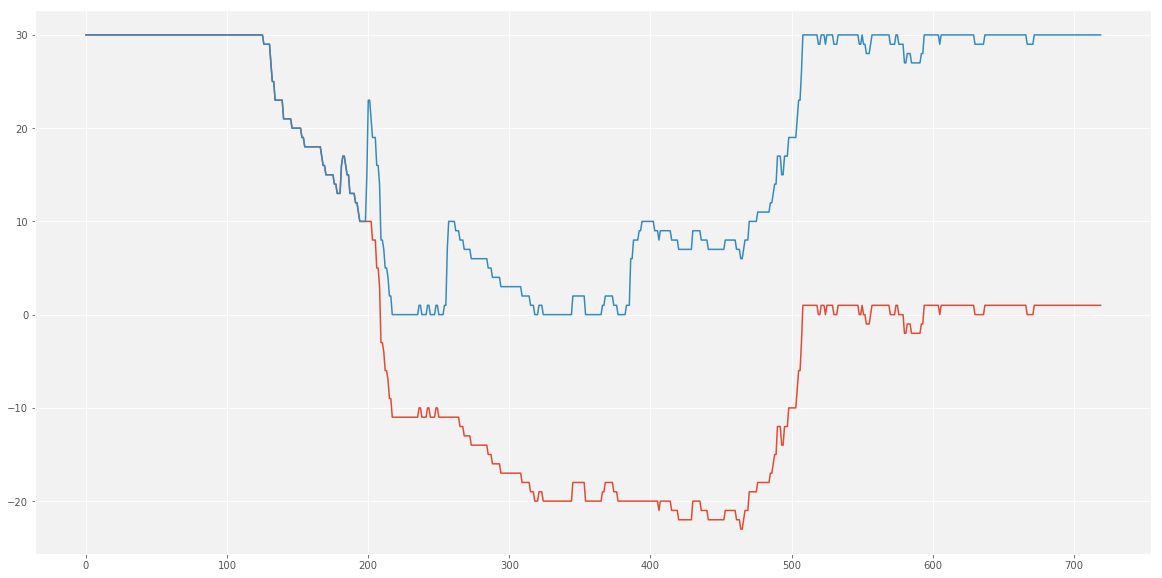

In [1052]:
plt.figure(figsize=(20,10))
plt.plot(no_peaks)
plt.plot(day.PORTOBELLO_ROAD.values);

In [ ]:
# to-do:  predict demand first, then eliminate peaks
# simulation?

In [ ]:
def generate_times_opt(rate_function,max_t,delta):
    t = numpy.arange(delta,max_t, delta)
    avg_rate = (rate_function(t) + rate_function(t + delta)) / 2.0
    avg_prob = 1 - numpy.exp(-avg_rate * delta / 1000.0)
    rand_throws = numpy.random.uniform(size=t.shape[0])

    return t[avg_prob >= rand_throws].tolist()

In [303]:
data1 = data.resample('2H').last().bfill()

In [122]:
ys = data.resample('2H').last().bfill()

### Training models

In [1426]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

def model_report(model, X_train, y_train, X_test, y_test, best_alpha = False):
    model_fit = model.fit(X_train, y_train)
    train_pred = model_fit.predict(X_train)
    test_pred = model_fit.predict(X_test)
    print("MSE train:", mean_squared_error(y_train, train_pred))
    print("R^2 train",r2_score(y_train, train_pred))
    print("MSE test:",mean_squared_error(y_test, test_pred))
    print("R^2 test:",r2_score(y_test, test_pred))
    if best_alpha:
        print("Best alpha:", model_fit.alpha_)

In [23]:
X = features.resample('2H').mean()
y = data['BOLTON_STREET'].resample('2H').last().bfill()
#y_lag = [[0]]
#y_lag.append([x for x in y[1:].values]) нужно же для каждого дня своё, а не просто шифт на 1
#X['y_lag'] = [x for subset in y_lag for x in subset ]

In [24]:
svr = SVR(kernel = 'rbf')
ridge = RidgeCV(alphas = [0.5, 0.9, 1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
preds = svr.fit(X_train, y_train).predict(X_test)

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
model_report(svr, X_train, y_train, X_test, y_test)

MSE train: 34.10004330898632
R^2 train 0.06761126584434851
MSE test: 35.35304338727514
R^2 test: -0.011078660152864739


In [27]:
model_report(ridge, X_train, y_train, X_test, y_test)

MSE train: 35.529846445463036
R^2 train 0.02851652556992823
MSE test: 34.008153143869286
R^2 test: 0.027384501574390874


In [28]:
import missingno as msno
msno.matrix(df.iloc[:,:34])

NameError: name 'df' is not defined

In [29]:
msno.matrix(df.iloc[:,34:-34])

NameError: name 'df' is not defined

In [30]:
msno.matrix(df.iloc[:,-34:])

NameError: name 'df' is not defined

# More fancy graphs

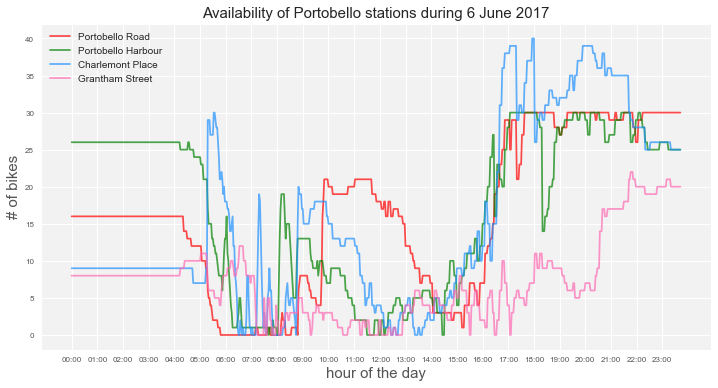

In [91]:
range_ = range(6, 7)
colors = ['black', 'red']#['grey', 'darkgrey', 'red']
figure, axis_weekdays = plt.subplots(1, 1, figsize=(12, 6))
for x, col in zip(range_, colors*len(range_)):
    for y in [6]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['PORTOBELLO_ROAD'].values, alpha = 0.7, color = 'r')

for x, col in zip(range_, colors*len(range_)):
    for y in [6]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['PORTOBELLO_HARBOUR'].values, alpha = 0.7, color = 'g')
for x, col in zip(range_, colors*len(range_)):
    for y in [6]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['CHARLEMONT_PLACE'].values, alpha = 0.7, color = 'dodgerblue')
for x, col in zip(range_, colors*len(range_)):
    for y in [6]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['GRANTHAM_STREET'].values, alpha = 0.7, color = 'hotpink')
                  
xticks = axis_weekdays.get_xticks()
xticks = range(0, 720, 30)
xticks_labels = ["%02d:%02d" % divmod(i*2, 60) for i in [int(tick) for tick in xticks]]
axis_weekdays.set_xticks(xticks)
axis_weekdays.set_xticklabels(xticks_labels)
axis_weekdays.tick_params(axis = 'both', labelsize = 8)

plt.ylabel('# of bikes')
plt.xlabel('hour of the day')
axis_weekdays.xaxis.label.set_fontsize(15)
axis_weekdays.yaxis.label.set_fontsize(15)
axis_weekdays.legend(['Portobello Road', 'Portobello Harbour', 'Charlemont Place', 'Grantham Street'])

plt.title('Availability of Portobello stations during 6 June 2017')
axis_weekdays.title.set_fontsize(15)

figure.savefig('Portobello_stations.png')
plt.show()

In [535]:
data['DATE'] = [x.date() for x in data.index]
data.columns = [x.replace("'",'') for x in data.columns.values]
dates = []
station_was_empty_3by2mins = []
station_was_full_3by2mins = []
for day in data.DATE.unique():
    dates.append(day)
    df_day = data[data.DATE == day]
    counter_stations_full = 0
    counter_stations_empty = 0
    for name, capacity in zip(stations.Name, stations.Capacity):
        if df_day[name.replace(' ', '_')][df_day[name.replace(' ', '_')] == capacity].shape[0] > 45:
            counter_stations_full += 1
        if df_day[name.replace(' ', '_')][df_day[name.replace(' ', '_')] == 0].shape[0] > 45:
            counter_stations_empty += 1
    station_was_full_3by2mins.append(counter_stations_full)
    station_was_empty_3by2mins.append(counter_stations_empty)   

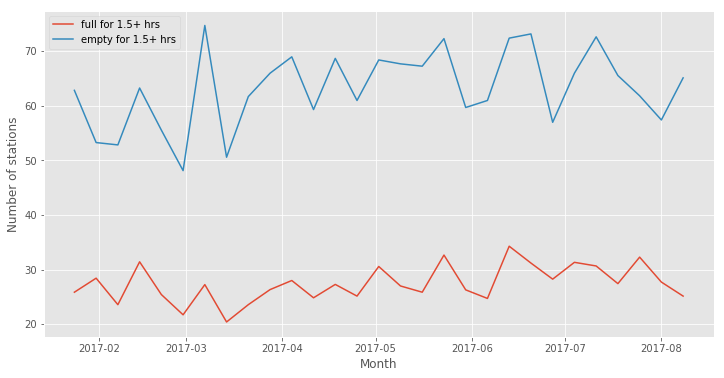

In [539]:
dff = pd.DataFrame({'full': station_was_full_3by2mins, 'empty': station_was_empty_3by2mins})
dff.index = pd.DatetimeIndex(dates)
dff = dff.sort_index(ascending=True)
dff['weekday'] = [x.weekday() for x in dff.index]
dff_week = dff[dff.weekday < 5]
dff_weekend = dff[dff.weekday >= 5]
dff = dff.resample('7D').mean().bfill()

fig = plt.figure(figsize=(12, 6))
plt.plot(dff['full'])
plt.plot(dff['empty'])
plt.legend(labels = ['full for 1.5+ hrs', 'empty for 1.5+ hrs'])
plt.xlabel('Month')
plt.ylabel('Number of stations')
fig.savefig('empty_full.png');

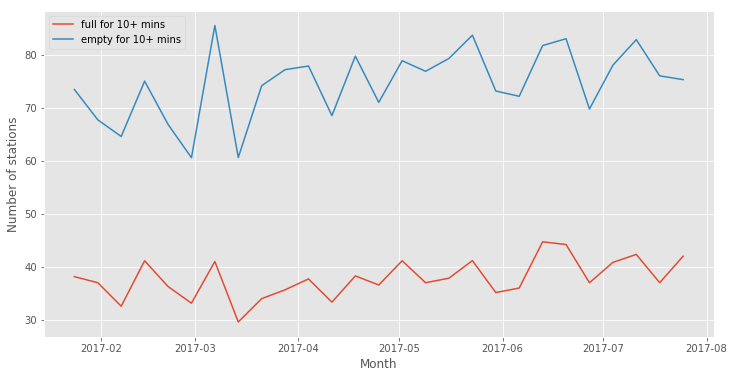

In [508]:
fig = plt.figure(figsize=(12, 6))
plt.plot(dff['full'][:-2])
plt.plot(dff['empty'][:-2])
plt.legend(labels = ['full for 10+ mins', 'empty for 10+ mins'])
plt.xlabel('Month')
plt.title('# of stations ')
plt.ylabel('Number of stations')
fig.savefig('empty_full.png');